## Assignment 3

#### Import Required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import data_cleaning
import scipy.stats

from sklearn.linear_model import LogisticRegression

#### Import CSV file

In [2]:
chess_data = data_cleaning.import_data()

In [3]:
# Find number of games in each time class

print("Games in Daily: " + str(len(chess_data[chess_data["time_class"] == "daily"])))
print("Games in Rapid: " + str(len(chess_data[chess_data["time_class"] == "rapid"])))
print("Games in Bullet: " + str(len(chess_data[chess_data["time_class"] == "bullet"])))
print("Games in Blitz: " + str(len(chess_data[chess_data["time_class"] == "blitz"])))

Games in Daily: 0
Games in Rapid: 12012
Games in Bullet: 21536
Games in Blitz: 27170


#### Logistic Regression

In [4]:
# empty wins and ELO difference array
wins = []
wins_split = [[] for _ in range(6)]
# diffs split
# 0 to 500 | 500 to 1k | 1k to 1.5k | 1.5k to 2k | 2k to 2.5k | 2.5k+
diffs = []
diffs_split = [[] for _ in range(6)]

# empty min and max arrays
min_split = [10000] * 6
max_split = [0] * 6

# range list
ranges = [500, 1000, 1500, 2000, 2500, 3000]

for i in range(len(chess_data)):
    # get the ratings of each and the results
    white = chess_data["white_rating"][i]
    black = chess_data["black_rating"][i]
    result = chess_data["white_result"][i]

    # find ELO mismatch size
    diff = white - black
    avg = (white + black) // 2
    # if white wins then append 1
    binary_result = 0
    if (result == "win"):    
        binary_result = 1
    wins.append(binary_result)
    # append the elo mismatch
    diffs.append(diff)
    
    # for each range going up
    for j in range(6):
        # if average is larger than the range
        if avg <= ranges[j]:
            # append to arrays
            diffs_split[j].append(diff)
            wins_split[j].append(binary_result)
            
            # if a respective min/max then redefine
            if diff <= min_split[j]:
                min_split[j] = diff
            if diff >= max_split[j]:
                max_split[j] = diff
            break

# set to numpy array to be able to do logistic regression
np_diffs = np.array(diffs).reshape(-1,1)
np_wins = np.array(wins)

# fit logistic regression for total graphs
total_model = LogisticRegression().fit(np_diffs, np_wins)

# list of logistic regressions
split_model = []

# for each elo range, make a logistic regression
for i in range(6):
    np_diffs_split = np.array(diffs_split[i]).reshape(-1,1)
    np_wins_split = np.array(wins_split[i])
    split_model.append(LogisticRegression().fit(np_diffs_split, np_wins_split))

# beta 1 and beta 0
beta0 = total_model.intercept_[0]
beta1 = total_model.coef_[0][0]
print("Beta 0: " + str(beta0) + ", Beta 1: " + str(beta1))


# Find predicted outcomes
predictions = total_model.predict(np_diffs)

Beta 0: 0.07628733795590731, Beta 1: 0.010752741560883166


### Wald statistics for Hypothesis test

In [5]:
# Generate predicted-probability matrix
predict_prob = total_model.predict_proba(np_diffs)

# Add 1's column at start of np_diffs matrix
np_diffs_1s = np.hstack([np.ones((np_diffs.shape[0], 1)), np_diffs])

# Initialise 0's matrix
# Insert diagonal entries containing variance of predictions
V = np.multiply(predict_prob[:,0], predict_prob[:,1])
# Find covariances matrix
cov_matrix = np.linalg.pinv(np.dot(np_diffs_1s.T * V, np_diffs_1s))
# Find standard errors
standard_errors = np.sqrt(np.diag(cov_matrix))

# Find Wald statistic (coefficients / standard error) ^ 2
total_model_stats = np.insert(total_model.coef_, 0, total_model.intercept_)
wald_stats =  (total_model_stats / standard_errors) ** 2

# Find p-value
p_val = 2 * (1 - (scipy.stats.norm(0, 1).cdf(wald_stats[0])))

# Display metrics
print(f'Covariance matrix: {cov_matrix}')
print(f'Total model stats: {total_model_stats}')
print(f'Standard errors: {standard_errors}')
print(f'Wald statistics: {wald_stats}')
print(f'p-val: {p_val}')

Covariance matrix: [[7.71906421e-05 1.86967975e-08]
 [1.86967975e-08 2.05154937e-08]]
Total model stats: [0.07628734 0.01075274]
Standard errors: [0.00878582 0.00014323]
Wald statistics: [  75.39460452 5635.8112951 ]
p-val: 0.0


### Produce Logistic Regression figures

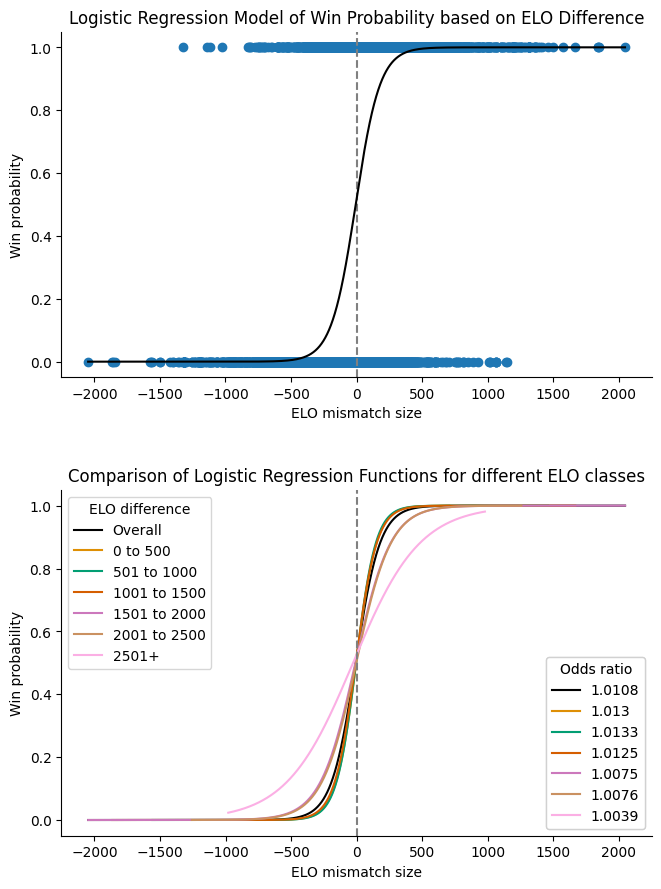

In [6]:
fig, ax1 = plt.subplots(2, 1, figsize=(8,10))
fig.tight_layout(pad=6.0)
# binary scatter plot
ax1[0].scatter(diffs, wins)
plt.setp(ax1, xticks=(np.arange(-2000, 2500, 500))) # Set tick labels

# np.arange for the range of values in the difference of ELO
x = np.arange(np_diffs.min(), np_diffs.max(), 0.1)
ax1[0].axvline(x = 0, color="gray", linestyle="dashed")

# plot logistic regression estimator
ax1[0].plot(x, total_model.predict_proba(np.reshape(x, (-1, 1)))[:,1], color="black")
ax1[0].set_title("Logistic Regression Model of Win Probability based on ELO Difference", fontsize=12)
ax1[0].set_xlabel("ELO mismatch size")
ax1[0].set_ylabel("Win probability")
ax1[0].spines[['right', 'top']].set_visible(False)

# Initialise array to record beta_1 for each logistic regression function
odds_ratio_array = [None] * 7
odds_ratio_array[0] = round(np.exp(beta1), 4)

# cmap = sns.color_palette("husl", 7)
cmap = sns.color_palette("colorblind")

# initialise label
labels = ["0 to 500", "501 to 1000", "1001 to 1500",
          "1501 to 2000", "2001 to 2500", "2501+", "Overall"]

# total plot line graph repeat
ax1[1].plot(x, total_model.predict_proba(np.reshape(x, (-1, 1)))[:,1], color="black", 
            label=labels[6])
ax1[1].set_axisbelow(True)

# for each subrange
for i in range(6):
    # set min and max
    x = np.arange(min_split[i], max_split[i], 0.1)
    # plot line graph
    ax1[1].plot(x, split_model[i].predict_proba(np.reshape(x, (-1, 1)))[:,1],
                color=cmap[i+1], label=labels[i])
    
    # get odds stuff
    beta_1 = split_model[i].coef_[0][0]
    odds_r = np.exp(beta_1)
    odds_ratio_array[i + 1] = round(odds_r, 4)

x = np.arange(np_diffs.min(), np_diffs.max(), 0.1)
ax1[1].spines[['right', 'top']].set_visible(False)
ax1[1].axvline(x = 0, color="gray", linestyle="dashed")
ax1[1].set_title("Comparison of Logistic Regression Functions for different ELO classes")
ax1[1].set_xlabel("ELO mismatch size")
ax1[1].set_ylabel("Win probability")

legend_elo = plt.legend(title="ELO difference" , loc="upper left")
legend_beta1 = plt.legend(odds_ratio_array, title="Odds ratio", loc="lower right")
ax1[1].add_artist(legend_elo)
ax1[1].add_artist(legend_beta1)

plt.savefig('report/images/log_regression_dual_exp.png', dpi=300)

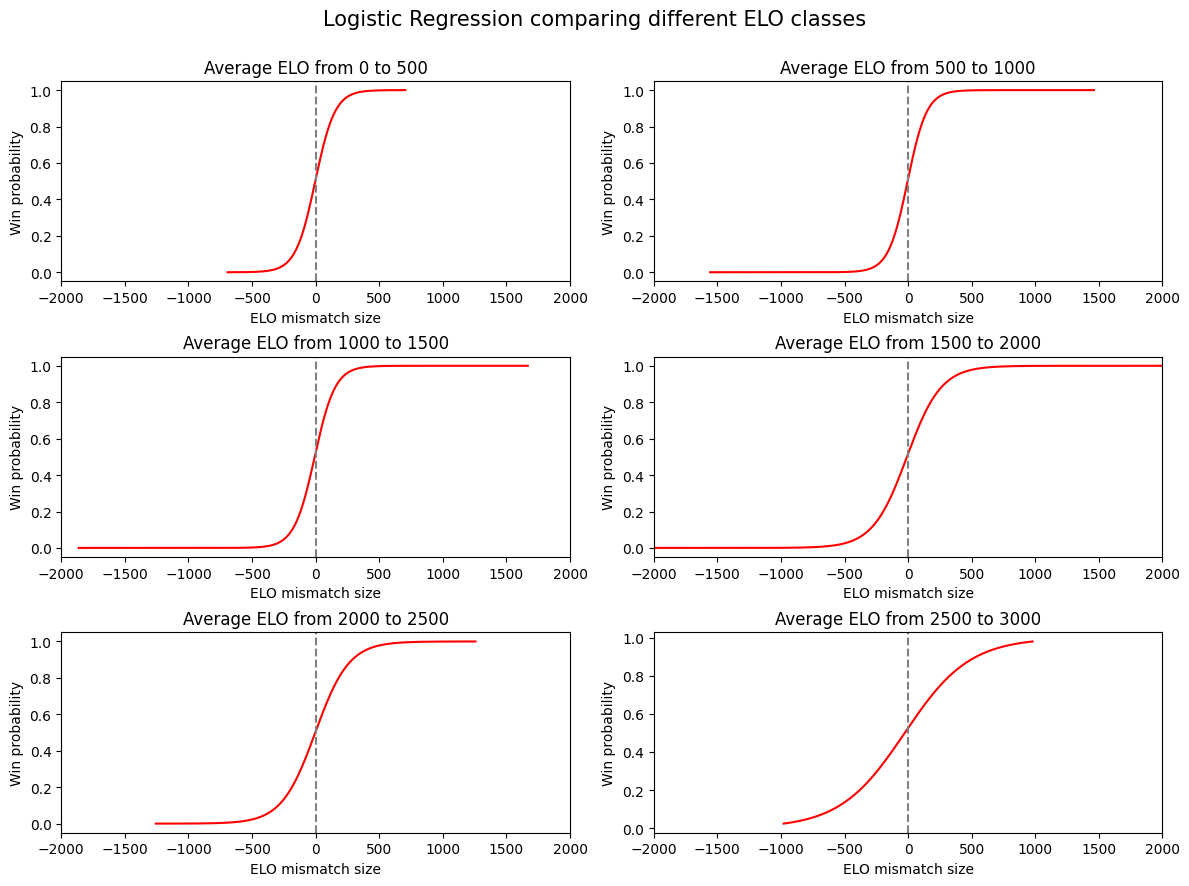

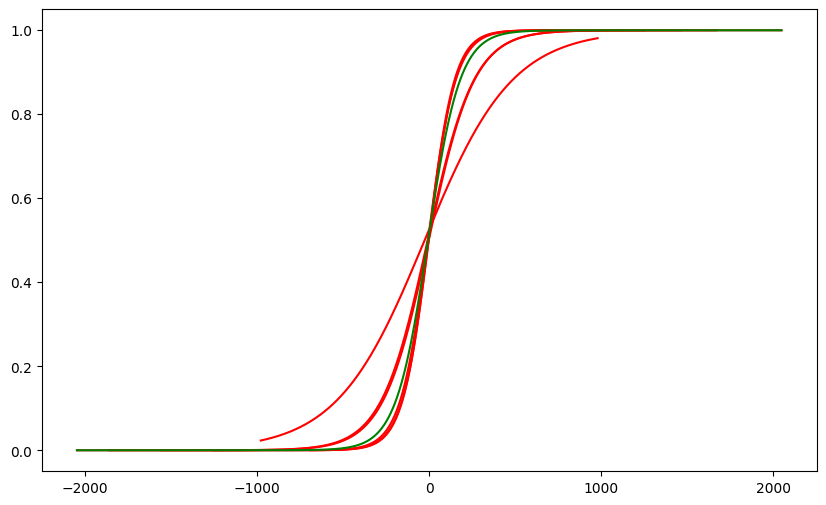

In [7]:
fig2, ax2 = plt.subplots(3,2,figsize=(12,9))
# binary scatter plot

# np.arange for the range of values in the difference of ELO

# plot logistic regresion estimator

for i in range(6):
    x = np.arange(min_split[i], max_split[i], 0.1)
    ax2[i//2][i%2].plot(x, split_model[i].predict_proba(np.reshape(x, (-1, 1)))[:,1], color="red")
    
    ax2[i//2][i%2].axvline(x = 0, color="gray", linestyle="dashed")
    ax2[i//2][i%2].set_xlabel("ELO mismatch size")
    ax2[i//2][i%2].set_ylabel("Win probability")
    ax2[i//2][i%2].set_xlim([-2000, 2000])
    ax2[i//2][i%2].set_title("Average ELO from "+ str(ranges[i]-500) + " to " + str(ranges[i]))

fig2.tight_layout()
fig2.suptitle("Logistic Regression comparing different ELO classes", fontsize=15)
fig2.subplots_adjust(top=0.9)

fig2, ax3 = plt.subplots(figsize=(10,6))
for i in range(6):
    x = np.arange(min_split[i], max_split[i], 0.1)
    ax3.plot(x, split_model[i].predict_proba(np.reshape(x, (-1, 1)))[:,1], color="red")

x = np.arange(np_diffs.min(), np_diffs.max(), 0.1)
ax3.plot(x, total_model.predict_proba(np.reshape(x, (-1, 1)))[:,1], color="green")

### Interpreting Logistic Regression Coefficients

In [8]:
def prob_win_same_elo(beta_0):
    '''
    Returns probability of a win with 0 difference in ELO between 2 players.
    '''
    return 1 / (1 + np.exp(beta_0))

def odds_ratio(beta_1):
    '''
    Returns odds ratio.
    '''
    return np.exp(beta_1)

# Interpret regression coefficients
print(f' Log odds of a win with 0 difference in ELO: {beta0} logits')
print(f' Probability of a win with 0 difference in ELO: {prob_win_same_elo(beta0)}')
print(f' Increase in log odds for every increase by 1 ELO point: {odds_ratio(beta1)}')

 Log odds of a win with 0 difference in ELO: 0.07628733795590731 logits
 Probability of a win with 0 difference in ELO: 0.4809374095862369
 Increase in log odds for every increase by 1 ELO point: 1.0108107600525644
